# Access to data on S3

Initially the data was stored on S3. To access S3, use following steps.

In [1]:
!pip install wget
!pip install seaborn
import wget
import sys
import os
import boto3
import pandas as pd
import numpy as np
import matplotlib as plt
from datetime import datetime
import seaborn as sns

  Stored in directory: /tmp/pip-ephem-wheel-cache-wzgn909n/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
os.environ['S3_ENDPOINT'] = 'https://s3.upshift.redhat.com' 
ceph_bucket = 'DH-PLAYPEN'
os.environ['AWS_ACCESS_KEY_ID']='FVCOYKA2QS37NFEFFA58'
os.environ['AWS_SECRET_ACCESS_KEY']='chC9tYxarMOq3lYMpnFDNayDLTqgJ6O9Tbh0EQpZ'

#Create a S3 client that will access Ceph
s3 = boto3.client('s3','us-east-1', endpoint_url= os.environ['S3_ENDPOINT'],
                       aws_access_key_id = os.environ['AWS_ACCESS_3 KEY_ID'],
                       aws_secret_access_key = os.environ['AWS_SECRET_ACCESS_KEY'])

ceph_bucket = ceph_bucket.upper()

#Define the location to upload data to Ceph
s3.create_bucket(Bucket=ceph_bucket)
ceph_base_location = os.environ['JUPYTERHUB_USER']


# Spark set-up

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles

spark = SparkSession.builder.appName(os.environ['JUPYTERHUB_USER'] + ' OSPO').master('spark://' + os.environ['SPARK_CLUSTER'] + ':7077').getOrCreate()

#Configure Spark to access data from Ceph
hadoopConf=spark.sparkContext._jsc.hadoopConfiguration()
hadoopConf.set("fs.s3a.endpoint", os.environ['S3_ENDPOINT'])
hadoopConf.set("fs.s3a.access.key", os.environ['AWS_ACCESS_KEY_ID'])
hadoopConf.set("fs.s3a.secret.key", os.environ['AWS_SECRET_ACCESS_KEY'])
hadoopConf.set("fs.s3a.path.style.access", "true")
hadoopConf.set("fs.s3a.connection.ssl.enabled", "false")

#Load csv to spark
#Change here when sample testing is done
df = spark.read.csv("s3a://" + ceph_bucket + "/" + "qrong/ospo-data/repos.csv", header="true")
# s3a://DH-PLAYPEN/qrong/ospo-data/repos.csv

In [4]:
# Dataframe's dimension
print((df.count(), len(df.columns)))

(52812768, 21)


# Exploratory phase 

In [ ]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

#Save a small sample
sample=repos_df.sample(False, 0.001, seed=0)
sample=df.toPandas()
sample.head(5) 

In [3]:
sample=pd.read_csv('sample.csv')
del sample["Unnamed: 0"]
del sample["author_affiliation"]

## Check if there are people from Massachusetts Open Cloud

In [ ]:
# Committers' names are: Jeremy Freudberg, Lars Kellogg-Stedman, lkatalin, Nathan Mokhtarzadeh, Ian Denhardt, 
# zenhack, nathanmokh, larsks, jeremyfreudberg

In [11]:
MOC_ls=['Jeremy Freudberg', 'Lars Kellogg-Stedman', 'lkatalin', 'Nathan Mokhtarzadeh', 'Ian Denhardt', 'zenhack', 'nathanmokh', 'larsks', 'jeremyfreudberg']

In [13]:
all(sample['committer_name'].isin(MOC_ls)==False)

True

## Use the whole data set to check if MOC people are there

In [21]:
MOC_df=repos_df.filter(repos_df['committer_name'].isin(MOC_ls))

In [26]:
MOC_df.groupby('committer_name').count().show()

+--------------------+-----+
|      committer_name|count|
+--------------------+-----+
|Lars Kellogg-Stedman|  690|
+--------------------+-----+



Only Lars Kellogg-Stedman is in the history and he's using the redhat email. 

   ## Prepare the data

### Do some checks on columns:
Check if certain columns are useful to be kept for next steps

In [18]:
#Check if "status" all = complete
all(sample["status"]=="Complete") #True

True

In [20]:
#Check if "author" all = "committer"
all((sample["author_email"]==sample["committer_email"])==False) #False

False

In [ ]:
#Check how many commit history is with committer affiliation
all(sample["committer_affiliation"]=="NULL") #True

### Delete the columns that are not useful at this stage:
"commit","author_raw_email","committer_raw_email","repos_id17","status"

In [6]:
sample.head(5)

,Unnamed: 0,repos_id0,author_name,author_email,author_date,author_affiliation,committer_name,committer_email,committer_date,added,removed,whitespace,filename,date_attempted,git,repos_name
0,0,200,Nicola Ferraro,ni.ferraro@gmail.com,2016-11-08 12:13:34 +0100,NaN,Nicola Ferraro,ni.ferraro@gmail.com,2016-11-08 13:50:18 +0100,40,1,3,components-starter/camel-ehcache-starter/src/m...,16-5-2019 20:03:37,https://github.com/apache/camel,camel
1,1,200,sebi,sebi@softvision.ro,2015-05-19 18:25:43 +0300,NaN,Claus Ibsen,davsclaus@apache.org,2015-06-06 10:27:02 +0200,17,0,1,components/camel-test-blueprint/src/test/resou...,16-5-2019 20:03:36,https://github.com/apache/camel,camel
2,2,200,lburgazzoli,lburgazzoli@gmail.com,2016-12-05 17:35:43 +0100,NaN,lburgazzoli,lburgazzoli@gmail.com,2016-12-06 13:12:39 +0100,2,0,0,components-starter/camel-optaplanner-starter/s...,16-5-2019 20:03:39,https://github.com/apache/camel,camel
3,3,200,Claus Ibsen,davsclaus@apache.org,2013-01-24 20:51:49 +0000,NaN,Claus Ibsen,davsclaus@apache.org,2013-01-24 20:51:49 +0000,1,0,0,components/camel-scala/src/test/scala/org/apac...,16-5-2019 20:03:26,https://github.com/apache/camel,camel
4,4,200,Babak Vahdat,bvahdat@apache.org,2013-01-22 20:52:20 +0000,NaN,Babak Vahdat,bvahdat@apache.org,2013-01-22 20:52:20 +0000,1,2,0,components/camel-cxf/src/test/java/org/apache/...,16-5-2019 20:01:01,https://github.com/apache/camel,camel


In [ ]:
list_del=["commit","author_raw_email","author_affiliation","committer_raw_email","committer_affiliation","repos_id17","status"]
for ele in list_del:
    del sample[ele]

In [5]:
sample.columns.values

array(['repos_id0', 'author_name', 'author_email', 'author_date',
       'committer_name', 'committer_email', 'committer_date', 'added',
       'removed', 'whitespace', 'filename', 'date_attempted', 'git',
       'repos_name'], dtype=object)

### Parse email domain and determin if it's company domain or not -- Committer

In [4]:
#Split out email domain 
sample["email_comp"]=sample['committer_email'].str.split('@', 1, expand=True)[1]
sample["email_comp"]=sample['email_comp'].str.split('[.]', 1, expand=True)[0]

In [7]:
sample.groupby("email_comp").count()

,repos_id0,author_name,author_email,author_date,committer_name,committer_email,committer_date,added,removed,whitespace,filename,date_attempted,git,repos_name
email_comp,,,,,,,,,,,,,,
,2,2,2,2,2,2,2,2,2,2,2,2,2,2
03a675c2-f56d-4096-908f-63dba836b7e4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
10ur,1,1,1,1,1,1,1,1,1,1,1,1,1,1
126,3,3,3,3,3,3,3,3,3,3,3,3,3,3
163,5,5,5,5,5,5,5,5,5,5,5,5,5,5
19e92222-5c0b-0410-8929-a290d50e31e9,4,4,4,4,4,4,4,4,4,4,4,4,4,4
1a063a9b-81f0-0310-95a4-ce76da25c4cd,41,41,41,41,41,41,41,41,41,41,41,41,41,41
1fifoto,1,1,1,1,1,1,1,1,1,1,1,1,1,1
23,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [5]:
email_list=sample["email_comp"].unique()

In [6]:
#Load in a personal email domain txt file to filter them out 
#!wget free_email_provider_domains.txt https://gist.github.com/5992856.git

email_txt=list(open('free_email_provider_domains.txt','r'))

In [7]:
#Parse email domain in the text file
tmp=[]
for ele in email_txt:
    tmp.append(ele.split(".",-1)[0])
email_txt=tmp

In [8]:
res=[]
for ele in sample["email_comp"]:
    res.append(str(np.where(ele in email_txt, 'RH/V', ele)))
sample["committer_affiliation"]=res

In [9]:
sample["committer_affiliation"].head()

0      RH/V
1    apache
2      RH/V
3    apache
4    apache
Name: committer_affiliation, dtype: object

In [24]:
sample.groupby(['committer_affiliation']).size().nlargest(10)

committer_affiliation
RH/V         9286
redhat       7623
microsoft    5867
kde          3847
None         2236
users        1758
github       1176
nokia        1066
apache       1010
apple         548
dtype: int64

### Parse email domain and determin if it's company domain or not -- Author

In [26]:
#Split out email domain 
sample["email_comp"]=sample['author_email'].str.split('@', 1, expand=True)[1]
sample["email_comp"]=sample['email_comp'].str.split('[.]', 1, expand=True)[0]

In [27]:
res=[]
for ele in sample["email_comp"]:
    res.append(str(np.where(ele in email_txt, 'RH/V', ele)))
sample["author_affiliation"]=res

In [28]:
del sample["email_comp"]

In [29]:
#Check if committer email still != author email
all(sample["committer_affiliation"]==sample["author_affiliation"]) #False 

False

### Parse dates for plotting
To parse timestamps into 3 parts: date, time and time zone.

In [30]:
#Committer date format modification
res=[]
for ele in sample["committer_date"]:
    res.append(datetime.strptime(str(ele),"%Y-%m-%d %H:%M:%S %z"))
sample["committer_date"]=res

In [32]:
#Attempted time format modification
res=[]
for ele in sample["date_attempted"]:
    res.append(datetime.strptime(str(ele),"%d-%m-%Y %H:%M:%S"))
sample["date_attempted"]=res

In [33]:
#Author date format modification
res=[]
for ele in sample["author_date"]:
    res.append(datetime.strptime(str(ele),"%Y-%m-%d %H:%M:%S %z"))
sample["author_date"]=res

## Plotting:
- Time (on date_attempted)
  - Year
  - Month
  - Day 
  - Timezone
    - Hour 
    - Minute 
- Popular Repos (Top 10)


### Time Plotting 

In [223]:
#Create features: year, month, day
year=[]
month=[]
day=[]
for ele in sample["committer_date"]:
    year.append(ele.year)
    month.append(ele.month)
    day.append(ele.day)
sample["committer_year"]=year
sample["committer_month"]=month
sample["committer_day"]=day

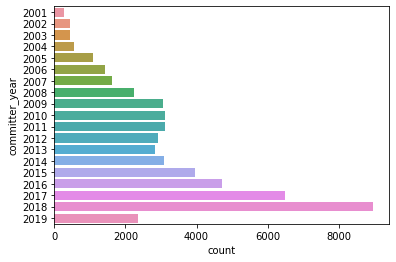

In [224]:
#Year Plot
%matplotlib inline
sns.countplot(y=sample["committer_year"],data=sample)

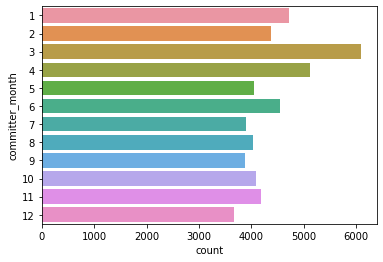

In [225]:
#Month Plot
%matplotlib inline
sns.countplot(y=sample["committer_month"],data=sample)

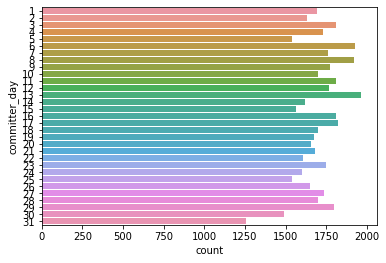

In [226]:
#Day Plot
%matplotlib inline
sns.countplot(y=sample["committer_day"],data=sample)

In [256]:
#Extract time zone
timezone=[]
for ele in sample["committer_date"]:
    timezone.append(str(str(ele.tzinfo).split("[.]",1)))
sample["committer_timezone"]=timezone   

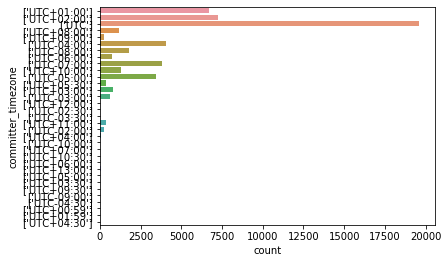

In [258]:
#Timezone Plot
%matplotlib inline
sns.countplot(y=sample["committer_timezone"],data=sample) 
#UTC timezone the most 
#UTC+1 & UTC+2 follow
#UTC+4 & UTC+5 & UTC+7 non-negligible 

In [259]:
#Look into UTC timezone 
tmp=sample[(sample["committer_timezone"]=="UTC")]
hour=[]
minute=[]
for ele in sample["committer_date"]:
    hour.append(ele.hour)
    minute.append(ele.minute)
sample["committer_minute"]=minute
sample["committer_hour"]=hour

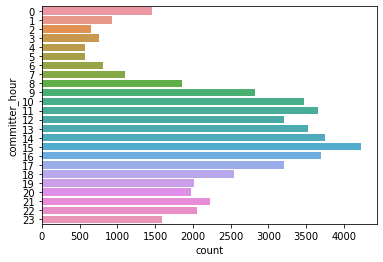

In [260]:
#Hour Plot in UTC timezone
%matplotlib inline
sns.countplot(y=sample["committer_hour"],data=sample)

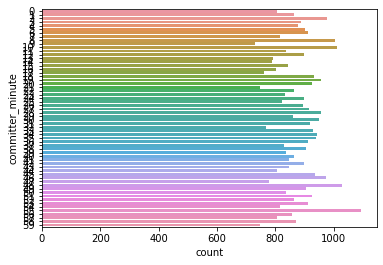

In [261]:
#Minute Plot in UTC timezone
%matplotlib inline
sns.countplot(y=sample["committer_minute"],data=sample)

### Repos Plotting 

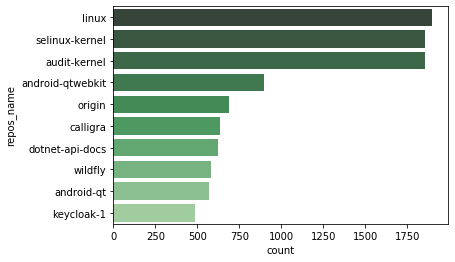

In [279]:
%matplotlib inline
sns.countplot(y=sample["repos_name"],
              data=sample,
             order=sample["repos_name"].value_counts().iloc[0:10].index,
             palette="Greens_d")
#The three most popular: linux, selinux-kernel, audit-kernel 

## Filter out RH/V and redhat dataset

In [75]:
sample_rh=sample[(sample["committer_affiliation"]=="RH/V") | (sample["committer_affiliation"]=="redhat")]

In [62]:
sample_rh.groupby("committer_affiliation").count()
#RH/V 9286
#redhat 7623

,repos_id0,author_name,author_email,author_date,committer_name,committer_email,committer_date,added,removed,whitespace,filename,date_attempted,git,repos_name,author_affiliation
committer_affiliation,,,,,,,,,,,,,,,
RH/V,9286,9286,9286,9286,9286,9286,9286,9286,9286,9286,9029,9286,9286,9286,9286
redhat,7623,7623,7623,7623,7623,7623,7623,7623,7623,7623,7451,7623,7623,7623,7623
